## Correlation of COVID-19 cases in the Municipalities of Mexico vs Comorbilities (Obesity, Hypertension, Diabetes)

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#### Import COVID-19 cases data in Municipalities

In [2]:
dfcvcases = pd.read_csv('../Data/week1analyzesMunicipalities.csv')
dfcvcases.sort_values('cve_ent',inplace=True, ascending = True)
dfcvcases.head()

,cve_ent,municipalitie,population,total_cases,cases_rate,cases_rate_last_60_days,total_deaths,deaths_rate,deaths_rate_last_60_days
42,1001,Aguascalientes,961977,22076,2294.857361,70.687761,2143,222.770399,7.484586
143,1002,Asientos,50864,464,912.236552,29.490406,36,70.776974,1.966027
262,1003,Calvillo,60760,982,1616.194865,8.229098,26,42.791310,0.000000
461,1004,Cosio,16918,130,768.412342,29.554321,12,70.930370,0.000000
817,1005,Jesus Maria,130184,779,598.383826,16.131015,62,47.624900,0.768144


In [3]:
dfcvcases.shape

(2457, 9)

In [4]:
dfcvcases['cve_ent'] = dfcvcases['cve_ent'].apply(lambda i: f'{i:05d}')

#### Import comorbilities data in Mexico 
##### Source:[https://www.inegi.org.mx/investigacion/pohd/2018/#Tabulados]

In [5]:
dfcomorb = pd.read_excel('../Data/comorbilidades_2018.xlsx', 
                         skiprows = range(0, 2), 
                         usecols=["Identificador único del municipio", 
                                  "Clave de entidad federativa", 
                                  "Entidad federativa", 
                                  "Clave de municipio o delegación", 
                                  "Municipio o delegación", "Estimador", 
                                  "Porcentaje de población de 20 años y más con obesidad.",
                                  "Porcentaje de población de 20 años y más con diagnóstico previo de hipertensión.",
                                  "Porcentaje de población de 20 años y más con diagnóstico previo de diabetes."])
#, nrows =32)
dfcomorb.head()

,Identificador único del municipio,Clave de entidad federativa,Entidad federativa,Clave de municipio o delegación,Municipio o delegación,Estimador,Porcentaje de población de 20 años y más con obesidad.,Porcentaje de población de 20 años y más con diagnóstico previo de hipertensión.,Porcentaje de población de 20 años y más con diagnóstico previo de diabetes.
0,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Valor,36.074883,18.384980,10.321339
1,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Error estándar,0.640200,0.301570,0.206737
2,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Límite inferior de confianza,35.021848,17.888941,9.981286
3,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Límite superior de confianza,37.127918,18.881019,10.661392
4,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Coeficiente de variación,1.774641,1.640308,10.321339


In [6]:
dfcomorb.rename(columns={"Identificador único del municipio":"cve_ent", 
                                  "Clave de entidad federativa":"code_state", 
                                  "Entidad federativa":"state", 
                                  "Clave de municipio o delegación":"code_municip", 
                                  "Municipio o delegación":"municipalitie",
                                  "Estimador":"estimator", 
                                  "Porcentaje de población de 20 años y más con obesidad.":"pct_obesity_up20years",
                                  "Porcentaje de población de 20 años y más con diagnóstico previo de hipertensión.":"pct_hypertension_up20years",
                                  "Porcentaje de población de 20 años y más con diagnóstico previo de diabetes.":"pct_diabetes_up20years"},
                                  inplace=True)
dfcomorb.head()

,cve_ent,code_state,state,code_municip,municipalitie,estimator,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Valor,36.074883,18.384980,10.321339
1,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Error estándar,0.640200,0.301570,0.206737
2,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Límite inferior de confianza,35.021848,17.888941,9.981286
3,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Límite superior de confianza,37.127918,18.881019,10.661392
4,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Coeficiente de variación,1.774641,1.640308,10.321339


In [7]:
dfcomorb.dtypes

cve_ent                        object
code_state                    float64
state                          object
code_municip                  float64
municipalitie                  object
estimator                      object
pct_obesity_up20years         float64
pct_hypertension_up20years    float64
pct_diabetes_up20years        float64
dtype: object

In [8]:
df_value = dfcomorb['estimator'] == "Valor"
df_value.head()

0     True
1    False
2    False
3    False
4    False
Name: estimator, dtype: bool

In [9]:
dfcomorbv=dfcomorb[df_value]
dfcomorbv.head()

,cve_ent,code_state,state,code_municip,municipalitie,estimator,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,00000,0.0,Estados Unidos Mexicanos,0.0,Total,Valor,36.074883,18.384980,10.321339
5,01000,1.0,Aguascalientes,0.0,Total,Valor,32.593387,14.700566,7.556478
10,01001,1.0,Aguascalientes,1.0,Aguascalientes,Valor,31.486541,14.942242,7.495861
15,01002,1.0,Aguascalientes,2.0,Asientos,Valor,32.282284,15.320425,7.953634
20,01003,1.0,Aguascalientes,3.0,Calvillo,Valor,40.004293,13.751906,9.172624


In [10]:
dfcomorbv.shape

(2490, 9)

In [11]:
dfcomorbv = dfcomorbv.query("municipalitie != 'Total'").copy()
dfcomorbv.shape

(2457, 9)

In [12]:
dfcomorbv.head()

,cve_ent,code_state,state,code_municip,municipalitie,estimator,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
10,01001,1.0,Aguascalientes,1.0,Aguascalientes,Valor,31.486541,14.942242,7.495861
15,01002,1.0,Aguascalientes,2.0,Asientos,Valor,32.282284,15.320425,7.953634
20,01003,1.0,Aguascalientes,3.0,Calvillo,Valor,40.004293,13.751906,9.172624
25,01004,1.0,Aguascalientes,4.0,Cosío,Valor,32.596450,16.431493,7.383116
30,01005,1.0,Aguascalientes,5.0,Jesús María,Valor,34.731715,12.356755,6.745819


In [13]:
dfcomorbv.sort_values('cve_ent',inplace=True, ascending = True)
dfcomorbv.head()

,cve_ent,code_state,state,code_municip,municipalitie,estimator,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
10,01001,1.0,Aguascalientes,1.0,Aguascalientes,Valor,31.486541,14.942242,7.495861
15,01002,1.0,Aguascalientes,2.0,Asientos,Valor,32.282284,15.320425,7.953634
20,01003,1.0,Aguascalientes,3.0,Calvillo,Valor,40.004293,13.751906,9.172624
25,01004,1.0,Aguascalientes,4.0,Cosío,Valor,32.596450,16.431493,7.383116
30,01005,1.0,Aguascalientes,5.0,Jesús María,Valor,34.731715,12.356755,6.745819


In [14]:
dfcomorbv=dfcomorbv.drop(['code_state', 'state', 'code_municip','municipalitie','estimator'], axis=1).copy()
dfcomorbv.head()

,cve_ent,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
10,01001,31.486541,14.942242,7.495861
15,01002,32.282284,15.320425,7.953634
20,01003,40.004293,13.751906,9.172624
25,01004,32.596450,16.431493,7.383116
30,01005,34.731715,12.356755,6.745819


In [15]:
#dfcomorbv.astype({'cve_ent': 'int64'}).dtypes
#dfcomorbv4=dfcomorbv3['pct_obesity_up20years','pct_hypertension_up20years','pct_diabetes_up20years'].astype(int)
#dfcomorbv.cve_ent = dfcomorbv.cve_ent.astype(int64)


In [16]:
#dfcomorbv.astype(int)
#dfcomorbv.astype('int32').dtypes


In [17]:
dfcomorbv.head()

,cve_ent,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
10,01001,31.486541,14.942242,7.495861
15,01002,32.282284,15.320425,7.953634
20,01003,40.004293,13.751906,9.172624
25,01004,32.596450,16.431493,7.383116
30,01005,34.731715,12.356755,6.745819


#### Merge Dataframes (COVID Cases / Comorbilities)

In [18]:
dfAll = pd.merge(dfcvcases, dfcomorbv,  on='cve_ent')
dfAll.head()

,cve_ent,municipalitie,population,total_cases,cases_rate,cases_rate_last_60_days,total_deaths,deaths_rate,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,01001,Aguascalientes,961977,22076,2294.857361,70.687761,2143,222.770399,7.484586,31.486541,14.942242,7.495861
1,01002,Asientos,50864,464,912.236552,29.490406,36,70.776974,1.966027,32.282284,15.320425,7.953634
2,01003,Calvillo,60760,982,1616.194865,8.229098,26,42.791310,0.000000,40.004293,13.751906,9.172624
3,01004,Cosio,16918,130,768.412342,29.554321,12,70.930370,0.000000,32.596450,16.431493,7.383116
4,01005,Jesus Maria,130184,779,598.383826,16.131015,62,47.624900,0.768144,34.731715,12.356755,6.745819


<AxesSubplot:>

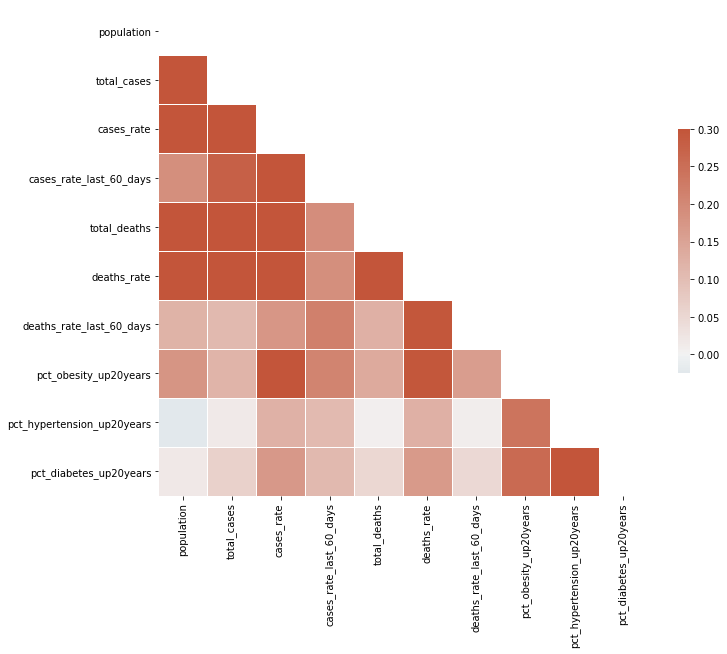

In [19]:
# Compute the correlation matrix
corr = dfAll.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
#a2 = dfAll[['population', 'total_cases', 'cases_rate', 'cases_rate_last_60_days', 'total_deaths', 'deaths_rate', 'deaths_rate_last_60_days', 'pct_obesity_up20years', 'pct_hypertension_up20years', 'pct_diabetes_up20years']]
a2 = dfAll[['pct_obesity_up20years']]
a3 = dfAll[['pct_hypertension_up20years']]
a4 = dfAll[['pct_diabetes_up20years']]

In [21]:
std_scaler = StandardScaler()
std_scaler
# fit and transform the data
X2 = pd.DataFrame(std_scaler.fit_transform(a2))
X3 = pd.DataFrame(std_scaler.fit_transform(a3))
X4 = pd.DataFrame(std_scaler.fit_transform(a4))

#X1.head(10)

In [22]:
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=2).fit(X2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
with np.printoptions(threshold=np.inf):
     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X2, labels))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Plot result

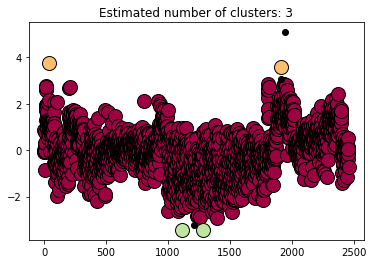

In [23]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X2[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X2[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [24]:
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=2).fit(X3)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
with np.printoptions(threshold=np.inf):
     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X3, labels))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

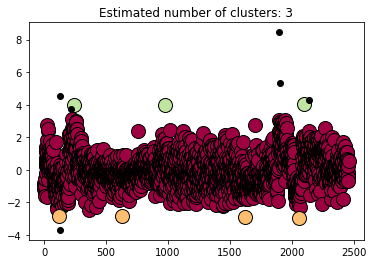

In [25]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X3[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X3[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [26]:
# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=2).fit(X4)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
with np.printoptions(threshold=np.inf):
     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X4, labels))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

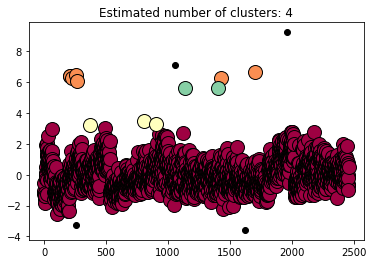

In [27]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X4[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X4[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, :], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()